# Introduction

The data set we aim to analyze discusses the potential correlational relationship between the number of sites in a London neighborhood and the average concentration of $\text{NO}_2$ on the roadsides on the neighborhood. The data was extracted from London Datastore, the official website for London's governmental databases. This data was measured in an observational manner, in December 23, where the number of construction sites across 31 neighborhoods of London was recorded, and a diffusion tube test was used to detect the average concentration of $\text{NO}_2$ gas along the roadsides of these neighborhood.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import scipy.stats as sts

In [33]:
# Initialize the packages

df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQsOGBgjUVC8puv4fyRuedFshy1_AdOTikL3czNtOzT2fzv4jF8GV7CkuZuLyjbh2jHzpFBhm1EvbF0/pub?gid=920293544&single=true&output=csv")
df = df.drop([3, 18, 28])

df

,Borough,Outer/Inner,Number of sites,Exceeding legal limit (40ugm-3),% exceeding legal limit,Exceeding WHO Guideline (10 ugm-3),% exceeding WHO guideline,Average Concentration Roadside*,Average Concentration Background**
0,Barking and Dagenham,Outer,28,0,0%,28,100%,29.4,13.5
1,Barnet,Outer,15,1,7%,15,100%,29.2,29.5
2,Brent,Outer,45,12,27%,45,100%,35.5,25.2
4,Camden,Inner,241,10,4%,241,100%,25.6,19.8
5,City,Inner,88,7,8%,88,100%,31.9,25.4
6,Croydon,Outer,30,4,13%,29,97%,27.2,13.6
7,Ealing,Outer,60,3,5%,60,100%,28.3,21.4
8,Enfield,Outer,21,2,10%,21,100%,45.6,17.8
9,Greenwich,Inner,42,0,0%,42,100%,26.1,16.1
10,H & F,Inner,56,7,13%,56,100%,27.8,19.6


[29.4 29.2 35.5 25.6 31.9 27.2 28.3 45.6 26.1 27.8 25.3 28.9 26.6 29.4
 25.7 28.7 31.6 29.4 22.2 32.7 26.5 30.4 27.3 27.2 28.1 27.5 28.1 30.8]


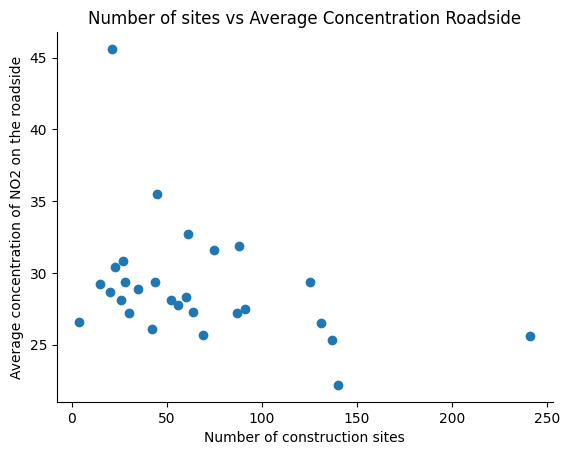

In [34]:
# @title Number of sites vs Exceeding legal limit (40ugm-3)

x = np.array(df['Number of sites'])
y = np.array(df['Average Concentration Roadside*'])
y_new = [float(num) for num in y]

print(y)
plt.scatter(x,y_new)
#df.plot(kind='scatter', x='Number of sites', y='Average Concentration Roadside*', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Number of construction sites")
plt.ylabel("Average concentration of NO2 on the roadside")
plt.title("Number of sites vs Average Concentration Roadside")
plt.show()

In [35]:
# Assuming 'df' is your original DataFrame and it contains columns 'Number of sites' and 'Average Concentration Roadside*'

# Create a new DataFrame with just the selected columns and rename them
df_sites = df[['Number of sites', 'Average Concentration Roadside*']].copy()
df_sites.rename(columns={'Number of sites': 'sites_num', 'Average Concentration Roadside*': 'concentration'}, inplace=True)



# with pm.Model() as m_4_5:
#     a = pm.Normal("a", mu=178, sigma=100)
#     b1 = pm.Lognormal("b1", mu=0, sigma=1)
#     b2 = pm.Normal("b2", mu=0, sigma=1)
#     sigma = pm.Uniform("sigma", lower=0, upper=50)
#     mu = pm.Deterministic("mu", a + b1 * d.weight_std.values + b2 * d.weight_std2.values)
#     height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
#     trace_4_5 = pm.sample(1000, tune=1000)


In [36]:
az.summary(df_sites.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
sites_num,65.607,51.497,4.0,140.0
concentration,29.036,4.174,22.2,35.5


# Model 1: Normal likelihood
## Likelihood
We choose the right likelihood to model to represent the prices between the average concentration of $\text{NO}_2$ on the roadsides in the neighborhoods. We propose the following model

$$
y \sim \text{Normal}(\mu, \sigma)
$$

$$
\mu_i = \beta_0 + \beta_1 x_i
$$

This likelihood model is chosen because it is a good starting point. This model is well-understood, and before incorporating any data into the model, the model highlights an understanding of a potential correlation between the number of construction sites in the neighborhood and the amount of air pollution on the roadsides, since the data generation process is highly observational and indicates no potential relationship between the independent variable and the dependent variable. The normal likelihood, due to its familiarity, simplifies the modeling process. Also, using the Central Limit Theorem (CLT), the sampling distribution would converge to a normal distribution given enough samples i.e. 30. Since the number of samples in this dataset is 31, we can assume that the CLT holds.

## Prior & prior-predictive

For each of the given parameters of the model, meaning $\beta_0$ (the regression intercept), $\beta_1$ (the regression coefficient), and $\sigma$ (the standard deviation of the normal distribution), we propose the following models for the parameters

### $\beta_1$ (Regression coefficient)

The report proposes that the coefficient follows a Normal distribution centered around 0 with a standard deviation of 4. Mathematically, this can be represented as

$$
\beta_1 \sim \text{Normal}(0, 0.1^2)
$$

While we may hypothesize that with more sites, the average $\text{NO}_2$ concentration in the road sides would increase, we set our mean of the distribution at around 0 to account for our skepticism at a potential positive relationship. Knowing that the data is measured up to 1 decimal point, we suspect that there is not much variability around the data, also considering that there is a baseline for the concentration of $\text{NO}_2$ and the concentration of this gas around London should not vary too much.


### $\beta_0$ (Regression intercept)

We expect that when there are no construction sites, there should still be a certain level of $\text{NO}_2$ in these areas. We also set the standard deviation to be at 4 to account for any variability. Hence,

$$
\beta_0 \sim \text{Normal}(20, 4^2)
$$

### $\sigma$ (Standard deviation)

We propose that the standard deviation follows a Normal distribution of

$$
\sigma \sim \text{Uniform}(0,20)
$$

since we do not have sufficient information on the standard deviation of this quantity.

With the given information, we have the following summary of the prior assumptions for model parameters.

$$
y \sim \text{Normal} (\mu, \sigma)
$$
$$
\mu = \beta_0 + \beta_1 x
$$
$$
\beta_0 \sim \text{Normal}(20,4^2)
$$
$$
\beta_1 \sim \text{Normal}(0,0.1^2)
$$
$$
\sigma \sim \text{Uniform}(0,20)
$$

After deciding the distributions for these parameters, we generate a prior-predictive distribution, which is shown below.


In [37]:
df_sites["concentration_std"] = (df_sites.concentration - df_sites.concentration.mean()) / df_sites.concentration.std()
df_sites["concentration_std2"] = df_sites.concentration_std**2

with pm.Model() as normal_model:
    b0 = pm.Normal("b0", mu=20, sigma=4)
    b1 = pm.Normal("b1", mu=0, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=20)
    # Data
    x = pm.MutableData('x', df_sites.sites_num)
    y = pm.MutableData('y', df_sites.concentration)
    # Regression mean
    mu = pm.Deterministic('mu', b0 + b1 * x)
    # Likelihood
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    #likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    # Generate prior predictive samples
    prior_predictive = pm.sample_prior_predictive(samples=500)

prior_predictive


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

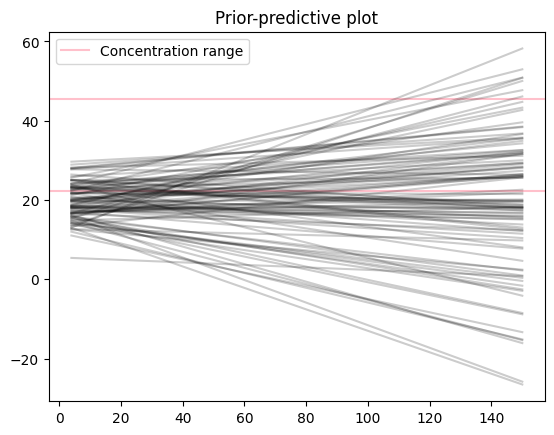

In [38]:
np.random.seed(2971)

# Prior-predictive plots

N = 100
b0 = sts.norm.rvs(loc=20, scale=4, size=N)
b1 = sts.norm.rvs(loc=0, scale=0.1, size=N)

# x = df_sites.sites_num
# y = df_sites.concentration

xbar = df_sites.concentration.mean()
x = np.linspace(df_sites.sites_num.min(), 150, 1000)
plt.axhline(df_sites.concentration.min(), ls="-", color="pink", label="Concentration range")
plt.axhline(df_sites.concentration.max(), ls="-", color="pink")
plt.legend()
for i in range(N):
    plt.plot(x, b0[i] + b1[i] * x, "k", alpha=0.2)
plt.title("Prior-predictive plot")
plt.show()

# Diagnostics

Before examining the results of the inference, we need to check if our `PyMC` sampler is working properly. Four ways for us to check this include summary statistics, rank plot, trace plot, and the posterior pair plot. These diagnostic tools indicate that the Bayesian model has exhibited satisfactory performance, demonstrating effective mixing and convergence across different chains as well as thorough exploration of the posterior distribution. Nevertheless, the observed absence of correlation between the regression coefficients $\beta_0$ and $\beta_1$ warrants additional scrutiny. This lack of correlation could influence how the model is interpreted.







In [57]:
# Sampling from PyMC with MCMC

with normal_model:
  normal_trace = pm.sample(1000)
  pm.compute_log_likelihood(normal_trace, progressbar=False)
  pm.sample_posterior_predictive(
      normal_trace,
      extend_inferencedata=True
  )


In [58]:
az.summary(normal_trace, ['b0', 'b1', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,29.914,1.303,27.199,32.155,0.044,0.031,891.0,877.0,1.0
b1,-0.019,0.016,-0.048,0.011,0.001,0.000,917.0,966.0,1.0
sigma,4.213,0.633,3.099,5.383,0.019,0.014,1107.0,1172.0,1.0


We assess the performance of the sampler using the summary statistics table shown above. We note that the ess values, which assess how many informative and independent samples are needed to make meaningful inferences. The summary table shows that this number ranges around 900-1300, which are around 1/8 of the total samples, meaning that the use of Markov chains allowed for the posterior distribution to be well-explored. We also notice an $\hat{r} = 1.0$ for all three parameters; hence, we infer that the chains converged to a true posterior distribution.

Another way to assess the performance of the sampler is through the use of rank plots, trace plots, and pair plots.

array([[<Axes: ylabel='b0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='b1'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='b0', ylabel='sigma'>, <Axes: xlabel='b1'>,
        <Axes: xlabel='sigma'>]], dtype=object)

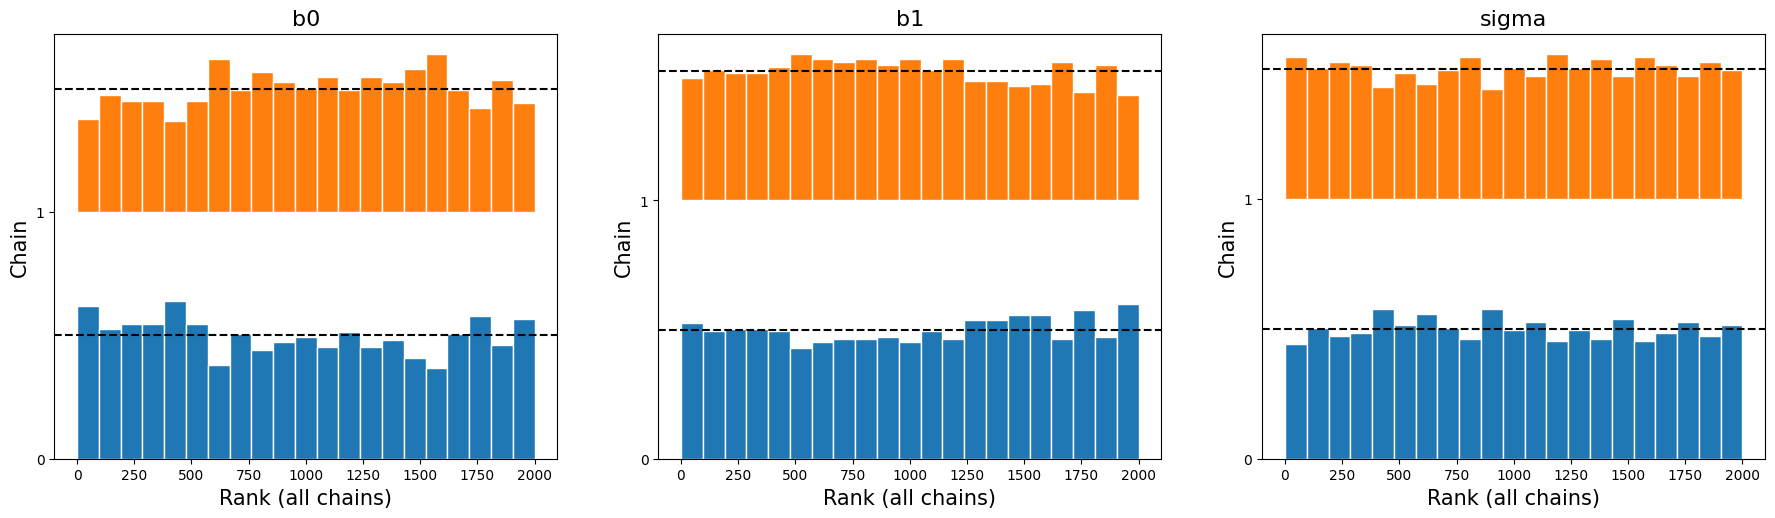

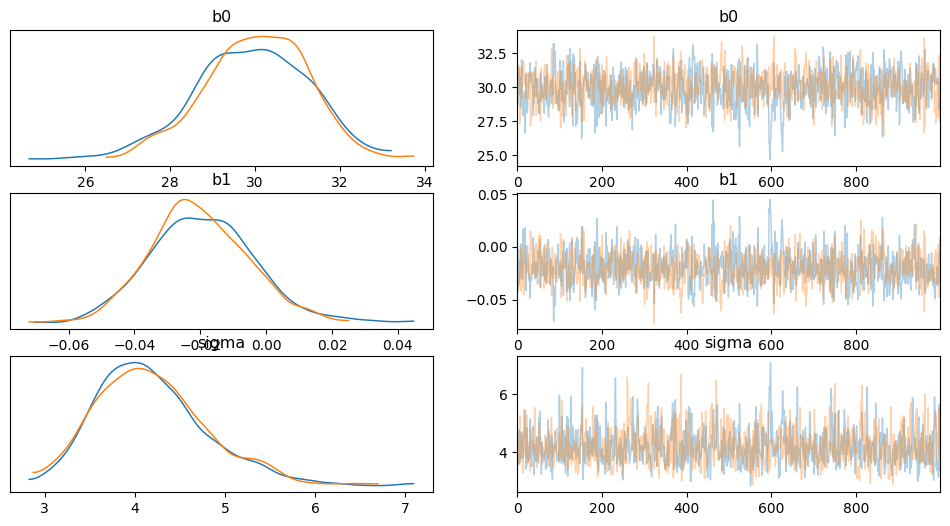

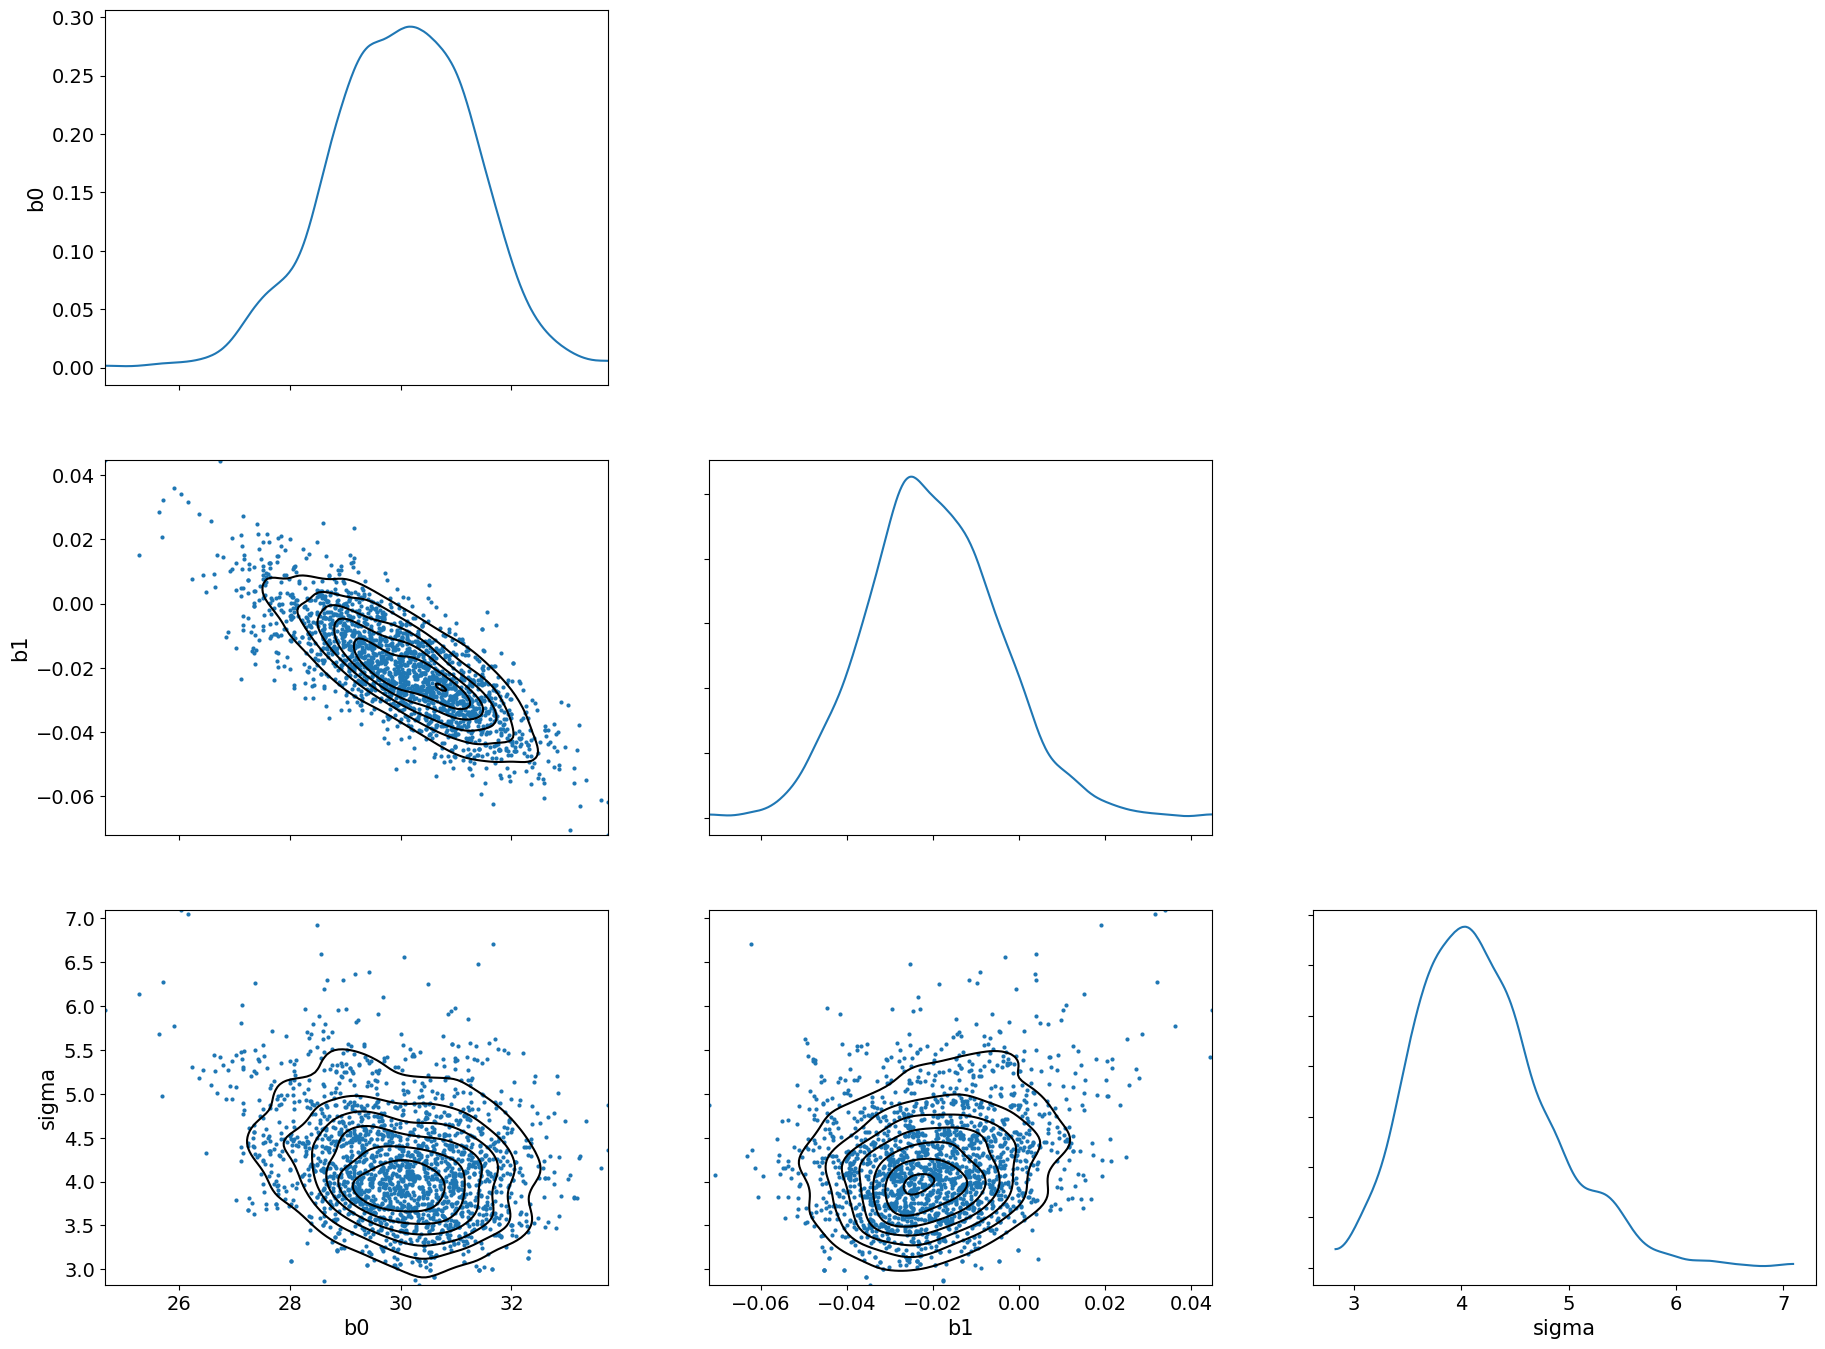

In [41]:

az.plot_rank(normal_trace, ['b0', 'b1', 'sigma'])
az.plot_trace(normal_trace, ['b0', 'b1', 'sigma'], compact=False)
az.plot_pair(normal_trace, var_names=['b0', 'b1', 'sigma'], marginals=True, kind=['kde', 'scatter'])


Looking at the rank plots, we notice that the ranks of the parameters are all uniformly distributed around the black dashed lines. From this, we infer that the Markov chains have conducted random walks and thus sufficiently explored the posterior distribution.

The trace plot showcases the convergence and mixing across the sampling chains. On the left side, every colored trajectory, symbolizing an MCMC chain for each parameter, merges into a shape that approximates normality, despite minor differences in tails and peaks. On the right side, the chains exhibit oscillations within a confined range, demonstrating their capacity to traverse the parameter space effectively without becoming trapped.

Finally, the pair plot matrix show the scatterplots of the parameters in pairs, as well as the marginal posterior plots of each parameter. The marginal posterior plots show that the sampler has found a best estimator from the posterior distribution, considering the fact that these plots only have one peak. Simultaneously, the scatterplots show that the standard deviation of $y$ are uncorrelated with the regression coefficients, while the regression coefficients are negatively correlated with each other. The correlation between $\beta_0$ and $\beta_1$ is expected: constrainted by the same mean of the data, the regression line would expect an increasing intercept as the coefficient decreases, and vice versa.

## Model interpretation

From the summary table, we propose that the Normal likelihood model has the mean of the regression line

$$
y = 29.914 - 0.019x
$$

and the mean of the standard deviation is $4.170$. The 94% High Density Interval of the regression coefficients are $[27.335, 32.144]$ for the intercept and $[-0.049, 0.009]$, stating a potential for a negative to a slightly positive correlation between number of sites and concentration of $\text{NO}_2$ on the road sides. Since 0 is included in the interval and this interval is very narrow, it is possible that there is no actual correlation between the two variables. Other statistics of the model parameters can be seen in the summary table.


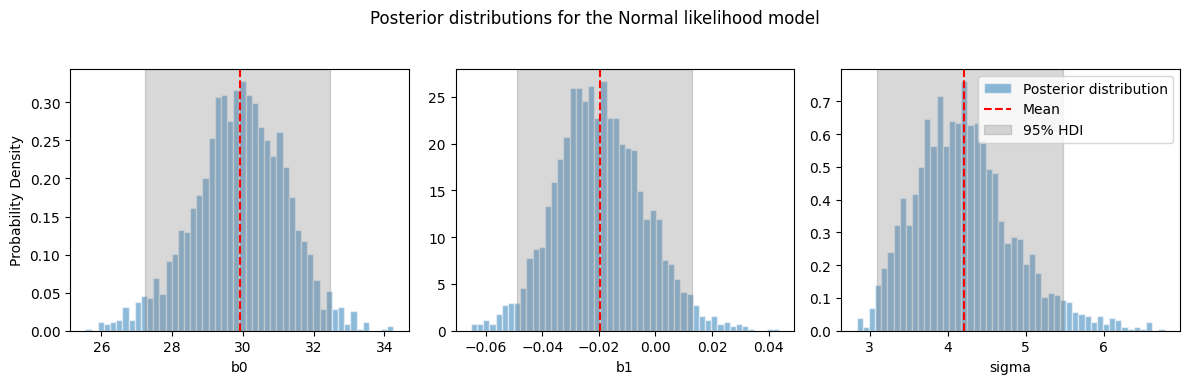

In [89]:
plt.figure(figsize=(12, 4))
plt.suptitle('Posterior distributions for the Normal likelihood model')

for i, var in enumerate(['b0', 'b1', 'sigma']):
    plt.subplot(1, 3, i+1)
    var_samples = getattr(normal_trace.posterior, var).values.flatten()
    var_mean = var_samples.mean()
    var_hdi = az.hdi(var_samples, hdi_prob=0.95)

    plt.hist(var_samples, density=True, bins=50, edgecolor='white', alpha=0.5, label=f'Posterior distribution')
    plt.axvline(var_mean, color='red', linestyle='--', label=f'Mean')
    plt.axvspan(var_hdi[0], var_hdi[1], color='gray', alpha=0.3, label=f'95% HDI')
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('Probability Density')
    if i == len(['b0', 'b1', 'sigma']) - 1:
        plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Model 2: Student's t Likelihood

## Likelihood

One major drawback of the Normal likelihood model is its lack of robustness to outliers, which one could see in the data, such as the Enfield and Camden neighborhoods. Visually, these data points seem far away from the rest of the data. Potentially, a more robust model would be the Student's t likelihood model. The Student's t likelihood model has an additional parameter $\nu$, related to the degrees of freedom. This parameter controls for the tail of the distribution and is able to adjust whether the distribution has a heavy or a light tail. The peak of the Student's t distribution is also narrower compared to a normal distribution, accounting for more variability and the embedded noise in the data.

Mathematically, we summarize the model as follows

$$
y \sim \text{Student-t}(\mu, \sigma, \nu)
$$
$$
\mu_i = \beta_0 + \beta_1 x_i
$$

## Prior & prior-predictive

This model attempts to retain similar assumptions on the regression coefficients as the Normal likelihood model, except that there is an additional shape parameter $\nu$ we need to account for. Since this parameter seems to have an arbitrary prior distribution, we set the prior distribution at $$\nu \sim \text{Half-Normal}(0, 30^2)$$
The main purpose of this arbitrary prior distribution is to ensure that the model is sufficiently robust to detect outliers in the data. The distribution is also a half-normal (truncated at 0) distribution instead of a normal distribution because the shape parameter $\nu$ can only take positive values. In summary,

$$
y \sim \text{Student-t} (\mu, \sigma, \nu)
$$
$$
\mu = \beta_0 + \beta_1 x
$$
$$
\beta_0 \sim \text{Normal}(20,4^2)
$$
$$
\beta_1 \sim \text{Normal}(0,0.1^2)
$$
$$
\sigma \sim \text{Uniform}(0,20)
$$
$$
\nu \sim \text{Half-Normal}(0, 30^2)
$$

In [42]:
with pm.Model() as student_t_model:
    b0 = pm.Normal("b0", mu=20, sigma=4)
    b1 = pm.Normal("b1", mu=0, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=20)
    nu = pm.HalfNormal('nu', sigma=30)
    # Data
    x = pm.MutableData('x', df_sites.sites_num)
    y = pm.MutableData('y', df_sites.concentration)
    # Regression mean
    mu = pm.Deterministic('mu', b0 + b1 * x)
    # Likelihood
    pm.StudentT('likelihood', mu=mu, sigma=sigma, nu=nu, observed=y)

    # Generate prior predictive samples
    prior_predictive = pm.sample_prior_predictive(samples=500)

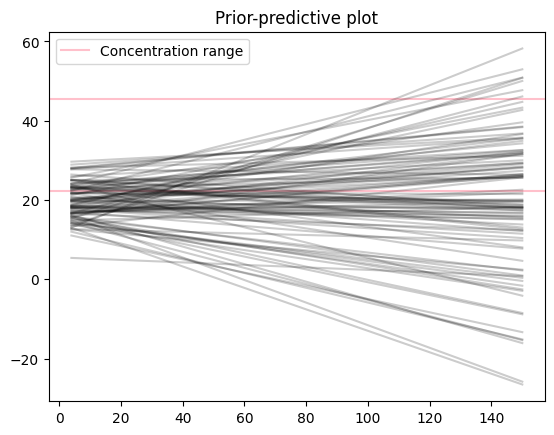

In [43]:
np.random.seed(2971)

# Prior-predictive plots

N = 100
b0 = sts.norm.rvs(loc=20, scale=4, size=N)
b1 = sts.norm.rvs(loc=0, scale=0.1, size=N)

x = np.linspace(df_sites.sites_num.min(), 150, 1000)
plt.axhline(df_sites.concentration.min(), ls="-", color="pink", label="Concentration range")
plt.axhline(df_sites.concentration.max(), ls="-", color="pink")
plt.legend()
for i in range(N):
    plt.plot(x, b0[i] + b1[i] * x, "k", alpha=0.2)
plt.title("Prior-predictive plot")
plt.show()


## Diagnostics

We continue using the same diagnostic table and plots to check whether computationally, our sampler is working properly. The purposes of these plots have been explained in model 1.

In [59]:
with student_t_model:
  student_t_trace = pm.sample(1000)
  pm.compute_log_likelihood(student_t_trace, progressbar=False)
  pm.sample_posterior_predictive(
      student_t_trace,
      extend_inferencedata=True
  )

In [60]:
az.summary(student_t_trace, ['b0', 'b1', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,29.209,0.790,27.789,30.794,0.027,0.019,887.0,842.0,1.00
b1,-0.017,0.010,-0.034,0.001,0.000,0.000,933.0,1021.0,1.01
sigma,2.131,0.730,0.896,3.471,0.030,0.021,598.0,503.0,1.00
nu,4.731,6.603,0.552,12.458,0.299,0.211,657.0,636.0,1.00


Similarly to previous analysis, the `ess` value retains at a good proportion compared to the number of samples we draw from the Markov chain (1,000 out of 8,000), which means that the Markov chain has sufficiently explored the posterior distribution, and the results converged to at true distribution as $\hat{r} ≈ 1.00$.

array([[<Axes: ylabel='b0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='b0', ylabel='nu'>, <Axes: xlabel='b1'>,
        <Axes: xlabel='sigma'>, <Axes: xlabel='nu'>]], dtype=object)

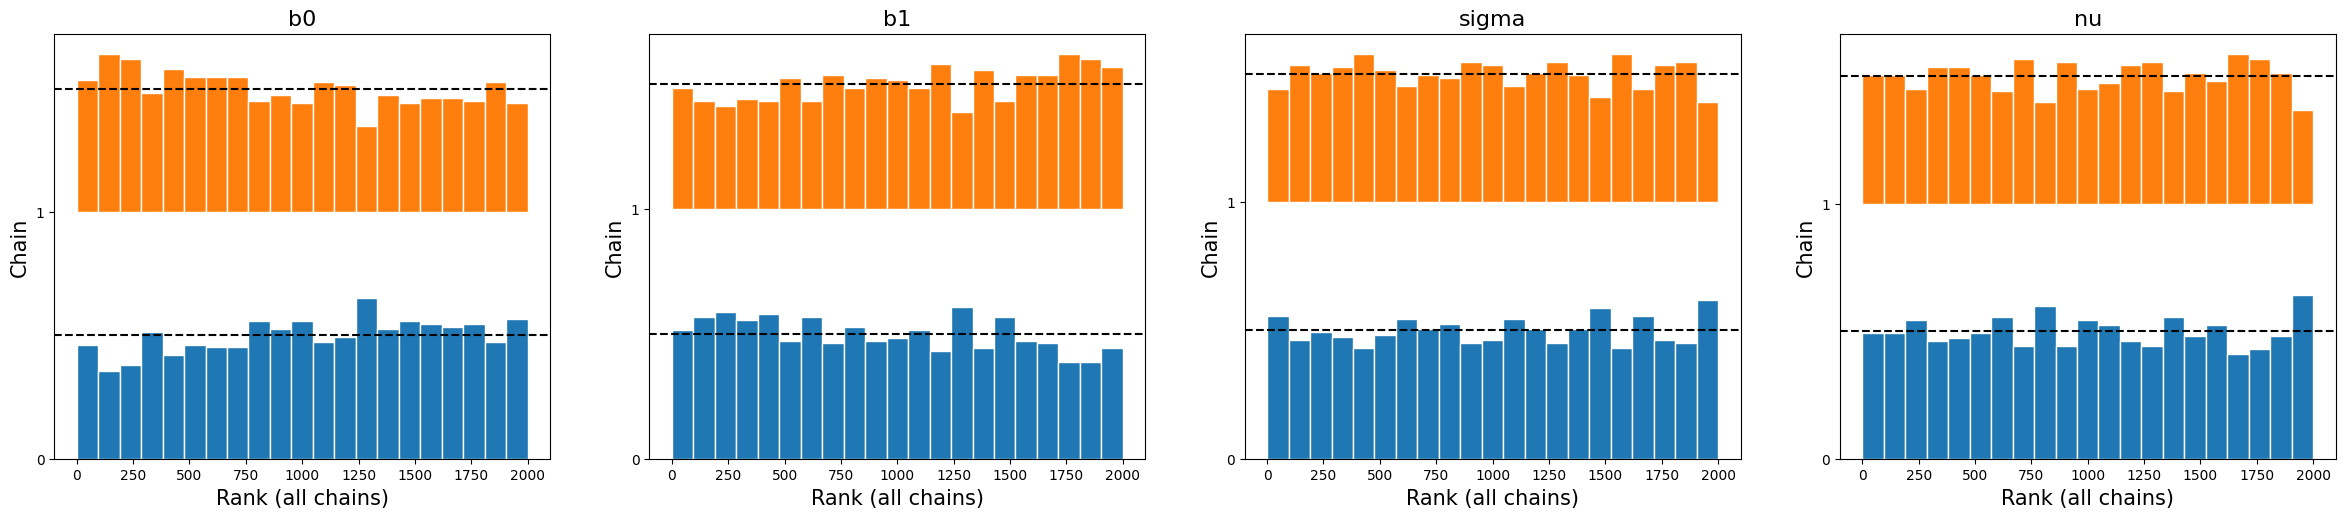

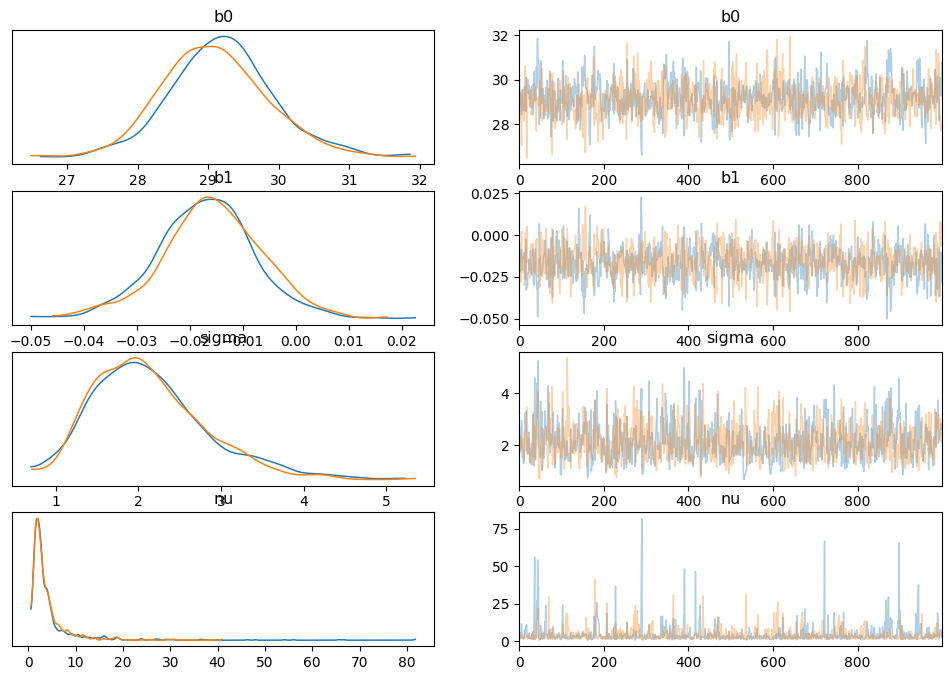

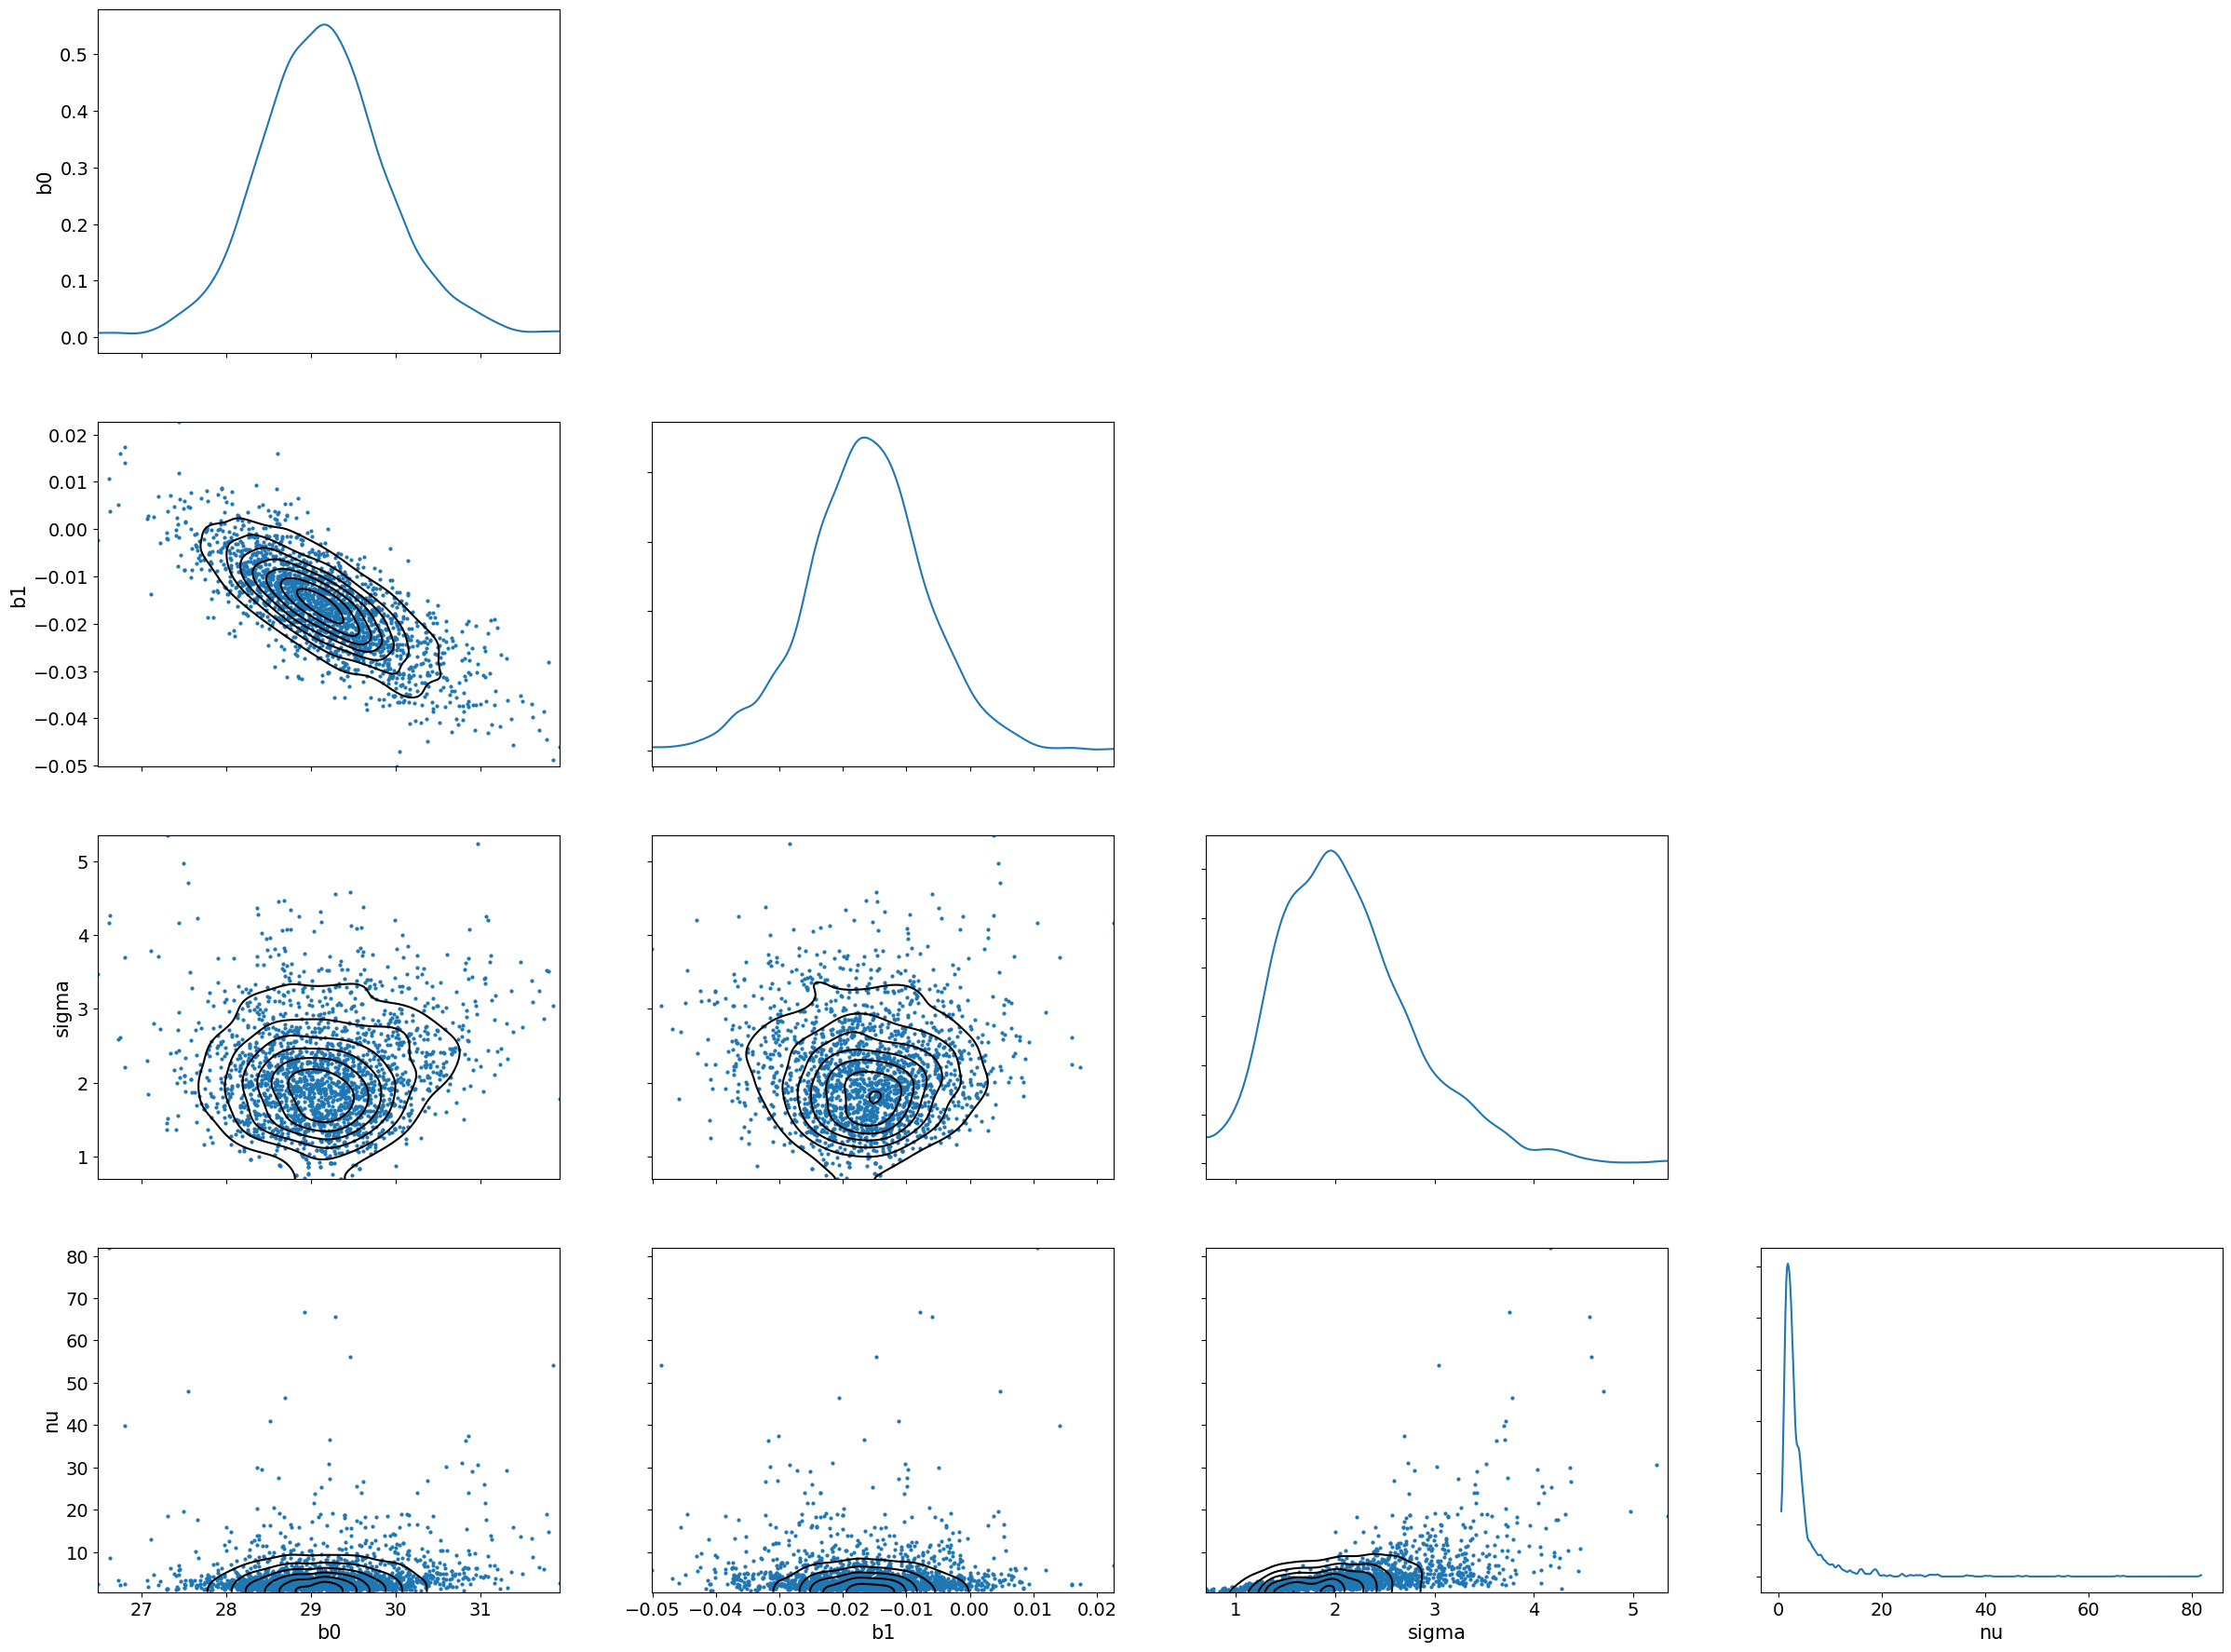

In [46]:
az.plot_rank(student_t_trace, ['b0', 'b1', 'sigma', 'nu'])
az.plot_trace(student_t_trace, ['b0', 'b1', 'sigma', 'nu'], compact=False)
az.plot_pair(student_t_trace, var_names=['b0', 'b1', 'sigma', 'nu'], marginals=True, kind=['kde', 'scatter'])

From the rank plots, we also notice a uniform distribution of the ranks along the dashed lines, showing that the walk was random and the distribution was well-explored. This is also supported by the randomness of the trace plots. The sampler converged to a true final posterior distribution, as shown by the unimodal KDE plots. $\sigma$ is still uncorrelated with the parameters $\beta_0$ and $\beta_1$, which are expectedly correlated with each other.

We note that there appears a new interaction between $\nu$ and the other parameters. One notices that for smaller values of $\nu$, the parameters tend to converge at a certain point, whereas the parameter values become more spread out for greater values of the shape parameter. This is also an expected feature of the diagnostics, as when $\nu$ is smaller, the likelihood function tends to be flatter (because when $\nu$ is large the distribution approaches a normal distribution), allowing for a wider range of values for $\sigma$ that can adequately explain the data.

## Model interpretation

From the summary table, we propose that the Normal likelihood model has the mean of the regression line

$$
y = 29.146 - 0.016x
$$

and the mean of the standard deviation is $2.071$, with the shape parameter having the mean of $3.929$. Once again, we also note that the 94% High Density Interval of the gradient of the regression line is narrow from $[-0.016, 0.010]$ and contains 0, once again stating that there might be no actual correlation between the two variables.



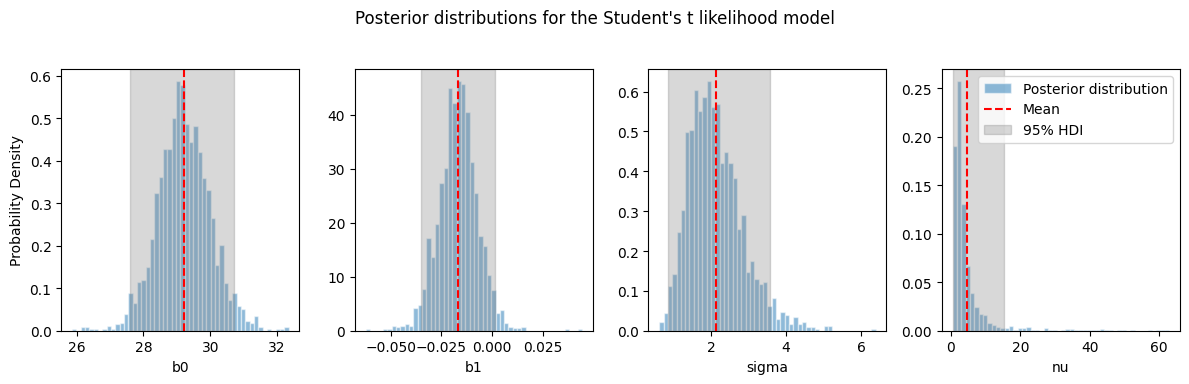

In [93]:
plt.figure(figsize=(12, 4))
plt.suptitle("Posterior distributions for the Student's t likelihood model")

for i, var in enumerate(['b0', 'b1', 'sigma', 'nu']):
    plt.subplot(1, 4, i+1)
    var_samples = getattr(student_t_trace.posterior, var).values.flatten()
    var_mean = var_samples.mean()
    var_hdi = az.hdi(var_samples, hdi_prob=0.95)

    plt.hist(var_samples, density=True, bins=50, edgecolor='white', alpha=0.5, label=f'Posterior distribution')
    plt.axvline(var_mean, color='red', linestyle='--', label=f'Mean')
    plt.axvspan(var_hdi[0], var_hdi[1], color='gray', alpha=0.3, label=f'95% HDI')
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('Probability Density')
    if i == len(['b0', 'b1', 'sigma', 'nu']) - 1:
        plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# Model Evaluation

## Pareto-Smoothed Importance Sampling Leave-One-Out Cross-Validation (PSIS-LOOCV)

In evaluating our models, it is essential to understand not only the model's current data fit but also its ability to generalize and predict new, unseen data points. To complement the Widely Applicable Information Criterion (WAIC) analysis, we turn to another robust measure of out-of-sample predictive accuracy known as Pareto-Smoothed Importance Sampling Leave-One-Out Cross-Validation (PSIS-LOOCV).

PSIS-LOOCV is an advanced method for estimating the pointwise out-of-sample prediction accuracy using importance sampling with Pareto smoothing. It serves as an approximation to the computationally intensive exact leave-one-out cross-validation (LOOCV) and is specifically designed to handle the potential instability in importance sampling via Pareto smoothing.

The cornerstone of PSIS-LOOCV is the leave-one-out cross-validation (LOOCV) approach, where the model is fitted to all data points except one and the omitted point is then predicted. By repeating this process for each data point, we obtain a series of predictive accuracies that provide insights into the model's performance on new data. The PSIS technique improves this process by stabilizing and correcting the importance ratios, thereby yielding reliable and efficient estimates of LOOCV.

The PSIS-LOOCV is quantified by the effective log predictive density (elpd_loo), which is the sum of the log predictive densities for each held-out point. It is defined as:

$$ \text{elpd_loo} = \sum_{i=1}^{n} \log p(y_i | \theta_{-i}) $$

where:
- $n$ is the number of observations in our data,
- $y_i$ represents the \(i\)th observation,
- $\theta_{-i}$ denotes the parameters estimated with the $i^{\text{th}}$ observation held out.

This elpd_loo value provides a single, summary measure of the model's predictive performance, where higher values indicate better out-of-sample prediction.

We apply a Pareto smoothing procedure to the importance weights to avoid the problems associated with long tails in their distribution. The smoothed weights lead to more accurate and stable estimates of the elpd_loo, which is crucial for models with influential observations that can otherwise dominate the importance sampling estimates.

By using PSIS-LOOCV, we address potential overfitting and assess the model's predictive performance in a way that is less sensitive to the influence of any single observation. This is especially valuable when the data set contains outliers or influential points that might overly impact the model's predictive checks.

Below, we present the PSIS-LOOCV results for each of our models. This will enable us to draw comparisons with the WAIC and provide a comprehensive view of each model's predictive capabilities.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


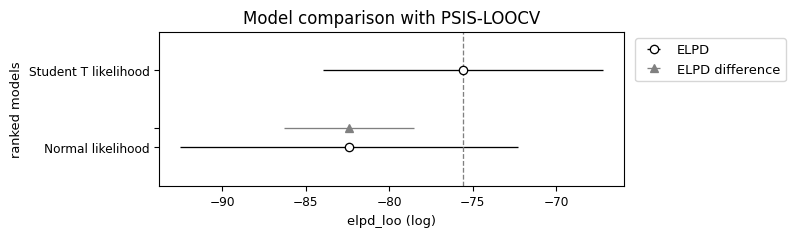

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T likelihood,0,-75.586289,5.735449,0.000000,1.000000e+00,8.406668,0.000000,True,log
Normal likelihood,1,-82.390146,5.310312,6.803857,2.930989e-14,10.136432,3.898926,True,log


In [96]:
inferences = {'Normal likelihood': normal_trace, 'Student T likelihood': student_t_trace}

def compare(model_dict: Dict[str,az.InferenceData]=inferences) -> pd.DataFrame:

    df_comparison = az.compare(model_dict, scale='log')
    az.plot_compare(df_comparison)
    plt.title('Model comparison with PSIS-LOOCV')
    plt.show()

    return df_comparison

compare()

Looking at the plot above which shows the PSIS-LOOCV in log scale, we notice that the Student's t Likelihood model has a stronger predictive accuracy since in log scale, it has a higher PSIS-LOOCV value (-75.5) compared to the Normal Likelihood value (-82.4). The weight of the Student's t model also proves to be much higher (almost 1) compared to the Normal likelihood model ($2.9 \times 10^{-14}$).

# AI Statement

The assignment used ChatGPT 4 in order to have some clarifications on the use of PSIS-LOOCV as a metric for model evaluation, and used ChatGPT also to help generate the plots to show the distributions of the parameters for both models.

# References

McElreath, R. (2020). Statistical Rethinking: A Bayesian Course with Examples in R and STAN (2nd edition). Chapman and Hall/CRC.

Minerva University CS College. (n.d.). Session 8.2: Robust linear regression: An exploration. Retrieved February 29, 2024, from https://sle-collaboration.minervaproject.com/?id=d0f17687-5061-4176-896d-0e596f69a3a4&userId=11968&name=An+%28he%2Fthey%29+Nguyen&avatar=https%3A//s3.us-east-1.amazonaws.com/picasso.fixtures/An_Nguyen_11968_2023-09-18T23%3A04%3A40.926Z&iframed=1&readOnly=0&isInstructor=0&enableSavingIndicators=1&signature=fcec0d6b353949ab98760a09c27fdcb09a9c9318b54548a39c6abc917832c7c7


# Video link

The link to the video is here: https://drive.google.com/file/d/1aHV_KaX6V8gw0UfcZQIdTcppEVY0yhRD/view?usp=drivesdk